<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_20ng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd gdrive/My\ Drive/MIT/

/content/gdrive/My Drive/MIT


In [9]:
! git clone https://github.com/albert-yue/gcn-explainability.git gcn_explainability

Cloning into 'gcn_explanability'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 6), reused 22 (delta 4), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [4]:
%cd gcn_explainability/

/content/gdrive/My Drive/MIT/gcn_explainability


In [52]:
! git pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9 (delta 7), reused 9 (delta 7), pack-reused 0
Unpacking objects: 100% (9/9), done.
From https://github.com/albert-yue/gcn-explanability
   d058c9e..f12580f  master     -> origin/master
Updating d058c9e..f12580f
Fast-forward
 src/preprocessing.py | 29 +++++++++++++++++++++--------
 src/train.py         | 36 +++++++++++++++++++++++++-----------
 2 files changed, 46 insertions(+), 19 deletions(-)


# Training

In [0]:
from src.data import Corpus, get_data, get_vocabulary, get_labels
from src.models.gcn import GCN
from src.preprocessing import clean_text, build_adj_matrix
from src.train import train, evaluate

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
seed = 0
val_split = 0.1

vocab = get_vocabulary('data/20ng-vocabulary.txt')
labels = get_labels('data/20ng-labels.txt')
corpus = get_data('data/train-20news.txt', labels)
test_corpus = get_data('data/test-20news.txt', labels)

# Split validation set
corpus.shuffle(seed)
len_train = int(len(corpus) * (1 - val_split))
train_corpus = Corpus(corpus[:len_train])
val_corpus = Corpus(corpus[len_train:])

num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)

In [5]:
# Mask out unknown words
clean_text(corpus, vocab)
clean_text(test_corpus, vocab)

NameError: ignored

In [14]:
train_adj_matrix = build_adj_matrix(train_corpus, vocab, num_documents, doc_offset=0)
val_adj_matrix = build_adj_matrix(val_corpus, vocab, num_documents, doc_offset=len(train_corpus))
test_adj_matrix = build_adj_matrix(test_corpus, vocab, num_documents, doc_offset=len(train_corpus) + len(val_corpus))

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(train_adj_matrix, 'data/20ng_train_adj_matrix.pt')
save_sparse_tensor(val_adj_matrix, 'data/20ng_val_adj_matrix.pt')
save_sparse_tensor(test_adj_matrix, 'data/20ng_test_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

train_adj_matrix = load_sparse_tensor('data/20ng_train_adj_matrix.pt')
val_adj_matrix = load_sparse_tensor('data/20ng_val_adj_matrix.pt')
test_adj_matrix = load_sparse_tensor('data/20ng_test_adj_matrix.pt')

In [0]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.sparse as sparse

# def normalize(mx):
#     """Row-normalize sparse matrix"""
#     rowsum = sparse.sum(mx, dim=1).to_dense()
#     rowsum = rowsum.unsqueeze(1)
#     d_inv_sqrt = torch.pow(rowsum, -0.5)
#     d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
#     print(d_inv_sqrt.size())
#     print(mx.size())
#     # mx_len = mx.size(0)
#     # inds = sparse.LongTensor([list(range(mx_len)), list(range(mx_len))])
#     # d_mat_inv_sqrt = sparse.FloatTensor(inds, d_inv_sqrt, torch.Size([mx_len, mx_len]))
#     return mx.mul(d_inv_sqrt).t().mul(d_inv_sqrt)

def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = adj.coalesce()
    sp_adj = sp.coo_matrix((adj.values(), adj.indices()), shape=list(adj.size()))

    rowsum = np.array(sp_adj.sum(axis=1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    norm_sp_adj = sp_adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

    entries = norm_sp_adj.data
    row = norm_sp_adj.row
    col = norm_sp_adj.col
    indices = torch.LongTensor([row, col])
    entries = torch.FloatTensor(entries)
    return sparse.FloatTensor(indices, entries, adj.size())

In [0]:
train_adj_matrix = normalize_adj(train_adj_matrix)
val_adj_matrix = normalize_adj(val_adj_matrix)
test_adj_matrix = normalize_adj(test_adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [59]:
%time train_losses, val_losses = train(model, train_adj_matrix, val_adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=500, plot_every=5, print_every=10, save_path='logs.pt')
print(train_losses)
print(val_losses)

Epoch 0
Train mean cross-entropy: 2.995659351348877
Validation mean cross-entropy: 2.9942779541015625
Epoch 10
Train mean cross-entropy: 2.9802796840667725
Validation mean cross-entropy: 2.9771625995635986
Epoch 20
Train mean cross-entropy: 2.958181381225586
Validation mean cross-entropy: 2.952011823654175
Epoch 30
Train mean cross-entropy: 2.931182861328125
Validation mean cross-entropy: 2.9209680557250977
Epoch 40
Train mean cross-entropy: 2.8988473415374756
Validation mean cross-entropy: 2.8844847679138184
Epoch 50
Train mean cross-entropy: 2.8608109951019287
Validation mean cross-entropy: 2.84249210357666
Epoch 60
Train mean cross-entropy: 2.816709041595459
Validation mean cross-entropy: 2.794619560241699
Epoch 70
Train mean cross-entropy: 2.767104148864746
Validation mean cross-entropy: 2.7406187057495117
Epoch 80
Train mean cross-entropy: 2.7101714611053467
Validation mean cross-entropy: 2.6803343296051025
Epoch 90
Train mean cross-entropy: 2.6484909057617188
Validation mean cros

In [73]:
more_train_losses, more_val_losses = train(model, train_adj_matrix, val_adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=200, plot_every=5, print_every=10, save_path='logs.pt')


Epoch 0
Train mean cross-entropy: 0.5063598155975342
Validation mean cross-entropy: 0.6885631084442139
Epoch 10
Train mean cross-entropy: 0.48068967461586
Validation mean cross-entropy: 0.6731424331665039
Epoch 20
Train mean cross-entropy: 0.45697686076164246
Validation mean cross-entropy: 0.6569337844848633
Epoch 30
Train mean cross-entropy: 0.4398645758628845
Validation mean cross-entropy: 0.642450213432312
Epoch 40
Train mean cross-entropy: 0.42041149735450745
Validation mean cross-entropy: 0.6293381452560425
Epoch 50
Train mean cross-entropy: 0.4063335955142975
Validation mean cross-entropy: 0.6168609261512756
Epoch 60
Train mean cross-entropy: 0.3865324854850769
Validation mean cross-entropy: 0.609488844871521
Epoch 70
Train mean cross-entropy: 0.3728535771369934
Validation mean cross-entropy: 0.5996378064155579
Epoch 80
Train mean cross-entropy: 0.3556421399116516
Validation mean cross-entropy: 0.5881234407424927
Epoch 90
Train mean cross-entropy: 0.34423771500587463
Validation m

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

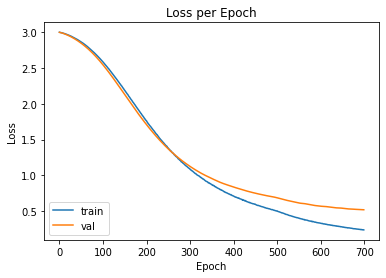

In [74]:
plot_loss(train_losses+more_train_losses, val_losses+more_val_losses)

In [0]:
from sklearn.metrics import accuracy_score
import torch

def accuracy(preds, targets):
    label_preds = torch.argmax(preds, dim=-1)
    return accuracy_score(targets, label_preds)

In [75]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, test_adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.8153212958045671
